In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Reproduce the action-inventory transformation from Toronto Paper

The idea is to extend points outwards away from the origin (by various amount) such that all feasible points can occupy the full square space. This mapping technique has a disadvantage that the transformed inventory q_t and action x_t does not correspond linearly to the actual inventory q and order placement x. This implementation requires both q and x to get q_t and x_t, and both q_t and x_t to recover q and x efficinetly. However, in application, we can only obtain q (from trading history) and x_t (from agent) easily, and solving x_t requires some additional computation (system of equations).  

In [2]:
def actionTransform(q0, q, x):
    '''
    q0 [float]: initial/full inventory
    q [float]: current/remaining inventory
    x [float]: current action/order placement
    '''

    # normalize and scale q and x
    q = q/q0 - 1
    x = x/q0

    if q == 0 or x == 0: # consider numerically-infeasible edge cases
        q_tilt = q
        x_tilt = x
    else:
        r=np.sqrt(q**2+x**2)
        zeta = -x/q
        theta = np.arctan(zeta)

        # for theta <= pi/4
        term1_1 = zeta**2+1
        term1_2 = 2*(np.cos(np.pi/4-theta))**2
        # for theta > pi/4
        term2_1 = zeta**(-2)+1
        term2_2 = 2*(np.cos(theta-np.pi/4))**2

        # compute the scaling factor for r
        if theta <= np.pi/4:
            r_tilt = r*np.sqrt(term1_1*term1_2)
        else:
            r_tilt = r*np.sqrt(term2_1*term2_2)

        # compute the scaled q and x
        q_tilt = -r_tilt*np.cos(theta)
        x_tilt = r_tilt*np.sin(theta)
    return q_tilt, x_tilt

def get_points(q0, resolution=100):
    '''
    Generate a list of feasible action-inventory combinations given initial inventory
    q0 [float]: initial/full inventory
    resolution [int]: max number of points to sample per axis
    '''
    gap = q0 / resolution
    points = []
    q = q0
    while q>0:
        x = 0
        while x <= q:
            color = 1 - q/q0 # 0 (black) for full inventory, 1 (white) for empty
            points += [(q, x, (color,color,color))]
            x += gap
        q -= gap
    return points

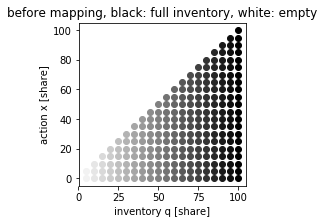

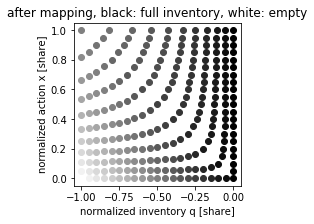

In [3]:
q0 = 100
resolution = 20
points = get_points(q0, resolution)

# generate plots before transformation
plt.figure(figsize = [3,3])
plt.xlabel("inventory q [share]")
plt.ylabel("action x [share]")
plt.title("before mapping, black: full inventory, white: empty")
for i, p in enumerate(points):
    plt.plot(p[0], p[1], "ro", color=p[2])
    
# generate plots after transformation
plt.figure(figsize = [3,3])
plt.xlabel("normalized inventory q [share]")
plt.ylabel("normalized action x [share]")
plt.title("after mapping, black: full inventory, white: empty")
for i, p in enumerate(points):
    q_tilt, x_tilt = actionTransform(q0, p[0], p[1])
    plt.plot(q_tilt, x_tilt, "o", color=p[2])

# our method

The idea is to identify a surface (in 3D) such that we can directly map action-inventory points to order placement in terms of %inventory. 

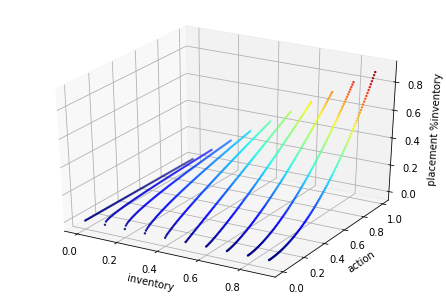

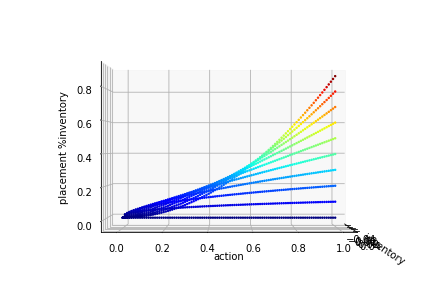

In [34]:
def get_points(resolution=100, steep_factor = 0):
 
    x_vec = [] # inventory
    y_vec = [] # action
    z_vec = [] # order placement %inventory

    more_y_points = 10 # only for ploting purposes
    for x in range(resolution):
        for y in range(resolution*more_y_points):
            # normalize x and y to be between 0 and 1
            x_tmp = x/resolution
            y_tmp = y/resolution/more_y_points

            # z=xy is a curved space where a linear trend is preserved when fixing x or y
            # It nicely satisfies the following constraints:
            #   - when x=0, z=0 for all y (when inventory is empty, all actions map to 0-order-placement)
            #   - when y=0, z=0 for all x (for all inventory level, 0-order-placement is always possible)
            #   - when y=1, z=x (when taking maximum action, the maximum possible order placement equals to the available inventory)
            # However, such formulation has one limitation. The action from the agent [0, 1] always represents a linear percentage
            # regardless of the remaining inventory volume. This is a bad strategy as the actual orderplacement magnitude is imbalanced 
            # at diffrent inventory volume (likely larger volume when inventory is full). To address this issue, we need to modify the 
            # level of curvature for lines with smaller fixed x value. For example, with x=0.1, z = 0.1y. However, we want the function to 
            # be something more like z = 0.1y^0.5. This way we can increase the probability of taking more "greedy" actions with larger 
            # %inventory. However, we only want to apply this change to small x values, as having this "saturation" effect to larger order
            # placement at larger remaining inventory does not make sense. therefore, we make the exponent of y as a function x.
            # This results in z=xy^x. In addition, we would like to control how much this curvature change we add to the surface, so we 
            # introduce a hyperparameter called steep_factor as the exponent of the exponent x making the final function z = xy^x^s where s 
            # is the steep factor.
            # In fact, we are not even limited by making the function concave. We can also have convex shape at larger inventory (more 
            # conservative actions). An example would be z = xy^(x+0.5)^s where the surface transition from convex to concave when moving 
            # from larger to smaller inventory. 
            # The optimal s value requires experimental validation. So far, s=0.5 seems to be a good starting point.
            
            # z_tmp = x_tmp*y_tmp**(x_tmp**steep_factor)
            z_tmp = x_tmp*y_tmp**(x_tmp+0.5)**steep_factor
            x_vec += [x_tmp]
            y_vec += [y_tmp]
            z_vec += [z_tmp]

    return x_vec, y_vec, z_vec

# compute dot data for generating the plot
resolution = 10
x,y,z = get_points(resolution, steep_factor = 2)

# generate the plot
from mpl_toolkits.mplot3d.axes3d import *
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter3D(x,y,z,c=z, cmap=plt.cm.jet, s=2)  
ax.set_xlabel("inventory")
ax.set_ylabel("action")
ax.set_zlabel('placement %inventory')
plt.show()

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter3D(0,y,z,c=z, cmap=plt.cm.jet, s=2)  
ax.set_xlabel("inventory")
ax.set_ylabel("action")
ax.set_zlabel('placement %inventory')
ax.azim = 0
ax.dist = 10
ax.elev = 0
plt.show()